In [1]:
import torch
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torch import optim
import torch.nn as nn
import os
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

### Задача 1

1). Создайте два вещественных тензора: `a` размером (3, 4) и `b` размером (12,)
2). Создайте тензор `c`, являющийся тензором `b`, но размера (2, 2, 3)
3). Выведите первый столбец матрицы `a` с помощью индексации

In [2]:
a = torch.Tensor(3, 4)
b = torch.Tensor(12, 1)
c = b.view(2, 2, 3)
a[:, 0]

tensor([9.2755e-39, 8.9082e-39, 1.0286e-38])

### Задача 2

1). Создайте два вещественных тензора: `a` размером (5, 2) и `b` размером (1,10)
2). Создайте тензор `c`, являющийся тензором `b`, но размера (5, 2)
3). Произведите все арифметические операции с тензорами `a` и `c`

In [3]:
a = torch.Tensor(5, 2)
b = torch.Tensor(1, 10)
c = b.view(5, 2)
print(a.add(c))
print(a.sub(c))
print(a.mul(c))
print(a.div(c))

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]])


### Задача 3

1). Создайте тензор *целых чисел* `images` размерности (100, 200, 200, 3) (можно интерпретировать это как 100 картинок размера 200х200 с тремя цветовыми каналами, то есть 100 цветных изображений 200х200). Заполните его нулями

2). Сделайте так, чтобы у $i$-ой по порядку картинки была нарисована белая полоса толщиной два пикселя в строках, которые соответствуют номеру картинки. Например, у 3-ей по порядку картинки белая полоска будет занимать 6 и 7 строки, у 99 - 198 и 199. Сделать белую строку можно, записав в ячейки тензора число 255 (по всем трём каналам). Выведите несколько примеров с помощью `pylot`

3). Посчитайте среднее тензора `images` по 1-ой оси (по сути - средняя картинка), умножьте полученный тензор на 70. Нарисуйте с помощью `pyplot`, должна получиться серая картинка (при взятии среднего нужно привести тензор к float с помощью `.float()`, при отрисовке обратно к int с помощью `.int()`)

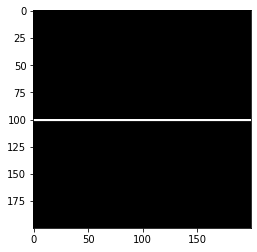

In [4]:

t = torch.Tensor(100, 200, 200, 3).zero_()
for i in range(0, 100):
    t[i, 2 * i:2 * i + 2] = 255
example = t[50]
plt.imshow(np.array(example / 255))

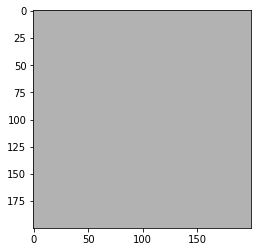

In [5]:
mean_t = t.mean(0)
mean_t = mean_t.mul(70)
plt.imshow(np.array(mean_t / 255))

### Задача 4

- В Colab нажмите в меню сверху: `Runtime` -> `Change Runtime Type` -> `GPU`, где изначально стоит `None` (`Среда выполнение` - `Сменить среду выполнения`)
- Объявите тензор `a` размера (2, 3, 4) и тензор `b` размера (1, 8, 3) на GPU, иницилизируйте их случайно равномерно (`.uniform_()`)
- Затем измените форму тензора `b`, чтобы она совпадала с формой тензора `a`, получите тензор `c`
- Переместите `c` на CPU, переместите `a` на CPU
- Оберните их в `Variable()`
- Объявите тензор `L = torch.mean((c - a) `**` 2)` и посчитайте градиент `L` по `c` ( то есть $\frac{\partial{L}}{\partial{c}})$
- Выведите градиент `L` по `c`

In [6]:
a = torch.Tensor(2, 3, 4).uniform_()
b = torch.Tensor(1, 8, 3).uniform_()
a = a.cuda()
a.is_cuda

True

In [7]:
c = b.view(2, 3, 4)
a = a.cpu()
c = c.cpu()
a = torch.autograd.Variable(a, requires_grad=False)
c = torch.autograd.Variable(c, requires_grad=True)

L = torch.Tensor(torch.mean((c - a) ** 2))
L.backward()

c.grad

tensor([[[ 0.0487,  0.0048,  0.0230,  0.0193],
         [ 0.0304,  0.0145, -0.0642,  0.0026],
         [-0.0068,  0.0342,  0.0271, -0.0759]],

        [[-0.0200, -0.0127, -0.0198,  0.0131],
         [-0.0614, -0.0101,  0.0217,  0.0362],
         [ 0.0061, -0.0318, -0.0104,  0.0095]]])

 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

Скачаем обучающую и контрольную выборки.

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress",
           "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot|

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [9]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [10]:
trainset.targets.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

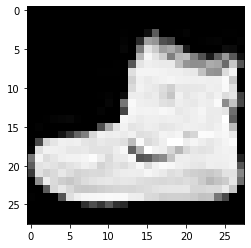

In [11]:
plt.imshow(trainset.data[0], cmap='Greys_r')

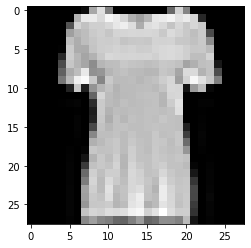

In [12]:
plt.imshow(trainset.data[10], cmap='Greys_r')

In [13]:
class MLP(torch.nn.Module):
    def __init__(self, input_layer_size, hidden_layer_size, output_layer_size):
        super().__init__()
        self.input_layer_size = trainset.data.shape[1] * trainset.data.shape[2]
        self.output_layer_size = len(trainset.targets.unique())
        self.hidden_layer_size = hidden_layer_size

        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(input_layer_size, hidden_layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_layer_size, output_layer_size)
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [35]:
def testing(test_loader, model):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            y_pred = model(images)
            _, predicted = torch.max(y_pred, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

    for i in range(10):
        print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]} %')
    print(f'Average accuracy: {round(float(100 * sum(class_correct) / sum(class_total)))} %')


In [16]:
lr = 1e-3
num_epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()
mlp = MLP(784, 128, 10)
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

for epoch in range(num_epochs):
    print(f'Starting epoch {epoch + 1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, targets = data
        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        current_loss += loss
        if i % 2500 == 2499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 2500))
            current_loss = 0.0

print('Training process has finished.')

Starting epoch 1
Loss after mini-batch  2500: 0.660
Loss after mini-batch  5000: 0.491
Loss after mini-batch  7500: 0.460
Loss after mini-batch 10000: 0.440
Loss after mini-batch 12500: 0.417
Loss after mini-batch 15000: 0.402
Starting epoch 2
Loss after mini-batch  2500: 0.366
Loss after mini-batch  5000: 0.376
Loss after mini-batch  7500: 0.385
Loss after mini-batch 10000: 0.356
Loss after mini-batch 12500: 0.364
Loss after mini-batch 15000: 0.371
Starting epoch 3
Loss after mini-batch  2500: 0.340
Loss after mini-batch  5000: 0.335
Loss after mini-batch  7500: 0.340
Loss after mini-batch 10000: 0.350
Loss after mini-batch 12500: 0.346
Loss after mini-batch 15000: 0.322
Starting epoch 4
Loss after mini-batch  2500: 0.316
Loss after mini-batch  5000: 0.327
Loss after mini-batch  7500: 0.323
Loss after mini-batch 10000: 0.308
Loss after mini-batch 12500: 0.322
Loss after mini-batch 15000: 0.318
Starting epoch 5
Loss after mini-batch  2500: 0.296
Loss after mini-batch  5000: 0.307
Loss 

In [17]:
testing(testloader, mlp)


Accuracy of T-shirt/top : 81.69999694824219 %
Accuracy of Trouser : 98.0999984741211 %
Accuracy of Pullover : 81.0 %
Accuracy of Dress : 87.9000015258789 %
Accuracy of Coat : 80.9000015258789 %
Accuracy of Sandal : 94.5999984741211 %
Accuracy of Shirt : 67.30000305175781 %
Accuracy of Sneaker : 92.69999694824219 %
Accuracy of Bag : 96.69999694824219 %
Accuracy of Ankle boot : 97.19999694824219 %
Average accuracy: 87.80999755859375


In [18]:
class Net(nn.Module):
    def __init__(self, l1, l2, first_conv_size, conv_kernel_size):
        super().__init__()

        self.feature_extractor = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=first_conv_size,
                                                         kernel_size=(conv_kernel_size, conv_kernel_size),
                                                         padding='same'),
                                               nn.ReLU(),
                                               nn.MaxPool2d(kernel_size=2, stride=2),
                                               nn.Conv2d(in_channels=first_conv_size, out_channels=2 * first_conv_size,
                                                         kernel_size=(conv_kernel_size, conv_kernel_size),
                                                         padding='same'),
                                               nn.ReLU(),
                                               nn.Flatten()
                                               )
        n_channels = self.feature_extractor(torch.empty(1, 1, 28, 28)).size(-1)
        self.classifier = nn.Sequential(nn.Linear(n_channels, l1),
                                        nn.ReLU(),
                                        nn.Linear(l1, l2),
                                        nn.ReLU(),
                                        nn.Linear(l2, 10))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [19]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    trainset = torchvision.datasets.FashionMNIST(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.FashionMNIST(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [23]:

def train_fashion_mnist(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"], config["first_conv_size"], config["conv_kernel_size"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-3)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=4,
        shuffle=True,
        num_workers=12)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=4,
        shuffle=True,
        num_workers=12)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [25]:
data_dir = os.path.abspath("./data")
load_data(data_dir)
config = {
    "l1": tune.sample_from(lambda _: 2 ** np.random.randint(6, 9)),
    "l2": tune.sample_from(lambda _: 2 ** np.random.randint(5, 8)),
    "first_conv_size": tune.choice([32, 64]),
    "conv_kernel_size": tune.choice([3, 5])
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=5,
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_fashion_mnist, data_dir=data_dir),
    resources_per_trial={"cpu": 12, "gpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))



2021-12-18 10:51:05,708	WARNING experiment.py:255 -- No name detected on trainable. Using DEFAULT.
2021-12-18 10:51:05,709	INFO registry.py:69 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Current time: 2021-12-18 10:51:05 (running for 00:00:00.19)
Memory usage on this node: 9.6/15.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/3.8 GiB heap, 0.0/1.9 GiB objects
Result logdir: C:\Users\ashee\ray_results\DEFAULT_2021-12-18_10-51-05
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+-----------------+--------------------+-------------------+------+------+
| Trial name          | status   | loc             |   conv_kernel_size |   first_conv_size |   l1 |   l2 |
|---------------------+----------+-----------------+--------------------+-------------------+------+------|
| DEFAULT_41249_00000 | RUNNING  | 127.0.0.1:15800 |                  3 |                32 |  128 |   32 |
| DEFAULT_41249_00001 | PENDING  |                 |                  3 |                64 |  128 |   32 |
| DEFAULT_41249_00002 | PENDING  |           

2021-12-18 11:34:25,381	INFO tune.py:626 -- Total run time: 2599.67 seconds (2599.54 seconds for the tuning loop).


Result for DEFAULT_41249_00009:
  accuracy: 0.8701666666666666
  date: 2021-12-18_11-34-25
  done: true
  experiment_id: 7c8777e51bc2416bbee7e0b44e901ccf
  hostname: DESKTOP-EGIN5B4
  iterations_since_restore: 1
  loss: 0.3435665490176131
  node_ip: 127.0.0.1
  pid: 21384
  should_checkpoint: true
  time_since_restore: 152.22159075737
  time_this_iter_s: 152.22159075737
  time_total_s: 152.22159075737
  timestamp: 1639816465
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '41249_00009'
  
== Status ==
Current time: 2021-12-18 11:34:25 (running for 00:43:19.55)
Memory usage on this node: 12.1/15.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 4.000: -0.26648298249124713 | Iter 2.000: -0.27451318651697065 | Iter 1.000: -0.2990813343433856
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/3.8 GiB heap, 0.0/1.9 GiB objects
Result logdir: C:\Users\ashee\ray_results\DEFAULT_2021-12-18_10-51-05
Number of trials: 10/10 (10 TERMINATED)
+---------------------+------------+-

In [36]:
best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"],
                          best_trial.config["first_conv_size"], best_trial.config["conv_kernel_size"])

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

testing(testloader, best_trained_model)


Accuracy of T-shirt/top : 84.19999694824219 %
Accuracy of Trouser : 98.5 %
Accuracy of Pullover : 86.80000305175781 %
Accuracy of Dress : 92.30000305175781 %
Accuracy of Coat : 83.5 %
Accuracy of Sandal : 98.9000015258789 %
Accuracy of Shirt : 74.0 %
Accuracy of Sneaker : 97.0 %
Accuracy of Bag : 97.69999694824219 %
Accuracy of Ankle boot : 96.80000305175781 %
Average accuracy: 91 %
